In [2]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ch3_practice"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 1. MNIST 데이터셋으로 분류기를 만들어서 테스트 세트에서 97% 정확도 달성
`KNeighborClassifier` 이용

`weight`, `n_neighbors` 하이퍼 파라미터에 대해 그리드 서치를 진행해서 좋은 하이퍼 파라미터값 탐색

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from sklearn.model_selection import cross_val_score

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [6]:
y = y.astype(np.uint8)

In [7]:
X_train, y_train, X_test, y_test = X[:60000],y[:60000],X[60000:],y[60000:] 

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'weights' : ['distance', 'uniform'],
     'n_neighbors' : [3,4,5]}
]
knn_clf = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_clf, param_grid, cv = 5, verbose = 2)

In [10]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. n_neighbors=3, weights=distance, total=12.4min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.4min remaining:    0.0s


[CV] .................. n_neighbors=3, weights=distance, total=12.4min
[CV] n_neighbors=3, weights=distance .................................
[CV] .................. n_neighbors=3, weights=distance, total=13.1min
[CV] n_neighbors=3, weights=distance .................................
[CV] .................. n_neighbors=3, weights=distance, total=12.9min
[CV] n_neighbors=3, weights=distance .................................
[CV] .................. n_neighbors=3, weights=distance, total=12.5min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=11.9min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=12.0min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=89.5min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 455.8min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['distance', 'uniform']}],
             scoring='neg_mean_squared_error', verbose=2)

In [11]:
knn_grid.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [16]:
from sklearn.metrics import accuracy_score

y_pred = knn_grid.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

# 2. MNIST 이미지를 (왼쪽, 오른쪽, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수 생성하고 훈련 세트에 있는 각 이미지에 대해서 네 개의 이동된 복사본(방향마다 한 개씩)을 만들어 훈련 세트에 추가

# 마지막으로 이 확장된 데이터셋에서 앞에서 찾은 최선의 모델을 훈련시키고 테스트 세트에서 정확도 측정해서 모델 성능이 높아졌는지 확인
`scipy.ndimage.interpolation` 모듈의 `shift()`함수 이용할 수 있음
- ex. shift(image,[2,1], cval = 0) 은 아래로 2픽셀, 오른쪽으로 1픽셀 이동 

In [23]:
some_digit = X[0]

In [24]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off") 

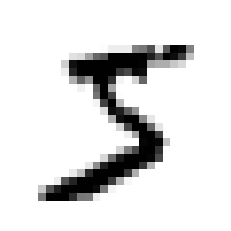

In [25]:
plot_digit(some_digit)

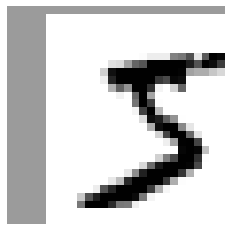

In [42]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new = 0): # new값이 커지면 새로 생긴 영역 어두워지고 기존 영역 밝아짐
    return shift(digit_array.reshape(28,28), [dy, dx], cval = new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new =100))

In [53]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1,0),(0,1),(-1,0),(0,-1)):
    shifted_images = np.apply_along_axis(shift_digit, axis = 1, arr = X_train, dx = dx, dy = dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
    
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [55]:
knn_clf = KNeighborsClassifier(weights = 'distance', n_neighbors = 4)
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [56]:
y_pred_expanded = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred_expanded)

0.9763

# 3. 타이타닉

In [117]:
import os

TITANIC_PATH = os.path.join('datasets', 'titanic')

In [118]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [119]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [120]:
train_data.head(20)

PassengerId  Survived  Pclass  \
0             1         0       3   
1             2         1       1   
2             3         1       3   
3             4         1       1   
4             5         0       3   
5             6         0       3   
6             7         0       1   
7             8         0       3   
8             9         1       3   
9            10         1       2   
10           11         1       3   
11           12         1       1   
12           13         0       3   
13           14         0       3   
14           15         0       3   
15           16         1       2   
16           17         0       3   
17           18         1       2   
18           19         0       3   
19           20         1       3   

                                                 Name     Sex   Age  SibSp  \
0                             Braund, Mr. Owen Harris    male  22.0      1   
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                              Heikkinen, Miss. Laina  female  26.0      0   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                            Allen, Mr. William Henry    male  35.0      0   
5                                    Moran, Mr. James    male   NaN      0   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
7                      Palsson, Master. Gosta Leonard    male   2.0      3   
8   Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                 Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   
12                     Saundercock, Mr. William Henry    male  20.0      0   
13                        Andersson, Mr. Anders Johan    male  39.0      1   
14               Vestrom, Miss. Hulda Amanda Adolfina  female  14.0      0   
15                   Hewlett, Mrs. (Mary D Kingcome)   female  55.0      0   
16                               Rice, Master. Eugene    male   2.0      4   
17                       Williams, Mr. Charles Eugene    male   NaN      0   
18  Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0      1   
19                            Masselmani, Mrs. Fatima  female   NaN      0   

    Parch            Ticket     Fare Cabin Embarked  
0       0         A/5 21171   7.2500   NaN        S  
1       0          PC 17599  71.2833   C85        C  
2       0  STON/O2. 3101282   7.9250   NaN        S  
3       0            113803  53.1000  C123        S  
4       0            373450   8.0500   NaN        S  
5       0            330877   8.4583   NaN        Q  
6       0             17463  51.8625   E46        S  
7       1            349909  21.0750   NaN        S  
8       2            347742  11.1333   NaN        S  
9       0            237736  30.0708   NaN        C  
10      1           PP 9549  16.7000    G6        S  
11      0            113783  26.5500  C103        S  
12      0         A/5. 2151   8.0500   NaN        S  
13      5            347082  31.2750   NaN        S  
14      0            350406   7.8542   NaN        S  
15      0            248706  16.0000   NaN        S  
16      1            382652  29.1250   NaN        Q  
17      0            244373  13.0000   NaN        S  
18      0            345763  18.0000   NaN        S  
19      0              2649   7.2250   NaN        C

- **survived** : 타깃( 0 : 생존하지 못함, 1 : 생존)
- **Pclass** : 승객 등급(1,2,3등석)
- **Name, Sex, Age** : 이름, 성별, 나이
- **SibSp** : 함께 탑승한 형제, 배우자의 수
- **Parch** : 함께 탑승한 자녀, 부모의 수
- **Ticked** : 티켓 아이디
- **Fare** : 티켓 요금(파운드)
- **Cabin** : 객실 번호
- **Embarked** : 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southamptom)

In [121]:
train_data.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

In [122]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age, Cabin, Embarked에서 null 존재하고 특히 Cabin은 685개의 null값이 존재

In [123]:
train_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [124]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

범주형 특성 확인

In [125]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [126]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [127]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [128]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

숫자 특성을 위한 파이프라인

In [129]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [130]:
num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(['Age', 'SibSp','Parch','Fare'])),
    ('imputer', SimpleImputer(strategy = 'median')),
])

In [131]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

문자열로 된 범주형 열을 처리하기 위해서 별도의 Imputer 클래스가 필요(`SimpleImputer`클래스는 처리하지 못함)

In [132]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index = X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [133]:
from sklearn.preprocessing import OneHotEncoder

범주형 특성을 위한 파이프라인

In [134]:
cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imputer', MostFrequentImputer()),
    ('cat_encoder',OneHotEncoder(sparse=False)),
])

In [135]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

숫자와 범주형 파이프라인 연결

In [136]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list =[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [137]:
X_train = preprocess_pipeline.fit_transform(train_data)
train_data

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [138]:
y_train = train_data['Survived']

In [139]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = 'auto')
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [140]:
X_test = preprocess_pipeline.fit_transform(test_data)
y_pred = svm_clf.predict(X_test)

In [141]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv = 10)
svm_scores.mean()

0.7329588014981274

In [142]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv = 10)
forest_scores.mean()

0.8126466916354558

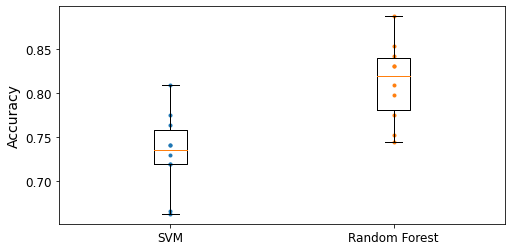

In [143]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [144]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [145]:
y_pred = forest_clf.predict(X_test)

In [152]:
res = np.c_[test_data['PassengerId'].values, y_pred]

In [153]:
res = pd.DataFrame(res)

In [154]:
res.columns = ['PassengerId','Survived']
res

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         1
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]

In [155]:
res.to_csv('titanic_res.csv', index = False)

# 4. 스팸 분류기 만들기
아파치 스팸어새신(Apache SpamAssassin)의 공공 데이터셋에서 스팸과 햄 샘플 내려받기

데이터셋의 압축을 풀고 데이터 형식 살펴보기

데이터셋을 훈련 세트와 테스트 세트로 나누기

각 이메일을 특성 벡터로 변환하는 데이터 준비 파이프라인 만들기. 이 준비 파이프라인은 하나의 이메일을 가능한 단어의 존재 여부를 나타내는 희소 벡터로 바꿔야함
- 예를 들어, 모든 이메일이 네 개의 단어 'Hello', 'how', 'are', 'you'만 포함한다면 'Hello you Hello Hello you'란 이메일은 벡터 [1, 0, 0, 1]로 표현되거나 단어의 출현 횟수에 관심이 있다면 [3, 0, 0, 2]로 변환

준비 파이프라인에 이메일 헤더 제거, 소문자 변환, 구두점 제거, 모든 URLs 주소를 'URL'로 대체, 모든 숫자를 'NUMBER'로 대체, 어간 추출 등을 수행할지 여부를 제어하기 위해 하이퍼파라미터 추가
- 대표적인 파이썬의 어간추출기로는 `nltk` 패키지의 `PorterStemmer`가 있다

여러 분류기 시도해보고 재현율과 정밀도가 모두 높은 스팸 분류기를 만들 수 있는지 확인

In [6]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [7]:
fetch_spam_data()

In [8]:
HAM_DIR = os.path.join(SPAM_PATH, 'easy_ham')
SPAM_DIR = os.path.join(SPAM_PATH, 'spam')
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [9]:
len(ham_filenames)

2500

In [10]:
len(spam_filenames)

500

In [11]:
ham_filenames

['00001.7c53336b37003a9286aba55d2945844c',
 '00002.9c4069e25e1ef370c078db7ee85ff9ac',
 '00003.860e3c3cee1b42ead714c5c874fe25f7',
 '00004.864220c5b6930b209cc287c361c99af1',
 '00005.bf27cdeaf0b8c4647ecd61b1d09da613',
 '00006.253ea2f9a9cc36fa0b1129b04b806608',
 '00007.37a8af848caae585af4fe35779656d55',
 '00008.5891548d921601906337dcf1ed8543cb',
 '00009.371eca25b0169ce5cb4f71d3e07b9e2d',
 '00010.145d22c053c1a0c410242e46c01635b3',
 '00011.fbcde1b4833bdbaaf0ced723edd6e355',
 '00012.48a387bc38d1316a6f6b49e8c2e43a03',
 '00013.81c34741dbed59c6dde50777e27e7ea3',
 '00014.cb20e10b2bfcb8210a1c310798532a57',
 '00015.4d7026347ba7478c9db04c70913e68fd',
 '00016.ef397cef16f8041242e3b6560e168053',
 '00017.08ef2d89f14cf7e2a458b80697eb1837',
 '00018.6fee38026193b5adde4b56892a6f14bc',
 '00019.5322cb10d8819b39499924d852819c27',
 '00020.d10651e31fcb92630c6229ec773cfe26',
 '00021.607c41268c5b0d66e81b58713a66d12c',
 '00022.48098f942c31097d2ef605df44dd8593',
 '00023.e0e815ea1d7fd40e7e70b4c0035bef0c',
 '00024.59c

파이썬의 email 모듈을 사용해 이메일 파싱(헤더, 인코더 등을 처리)

In [15]:
import email
import email.policy

def load_email(is_spam, filename, spam_path = SPAM_PATH):
    directory = 'spam' if is_spam else 'easy_ham'
    with open(os.path.join(spam_path, directory, filename), 'rb') as f:
        return email.parser.BytesParser(policy = email.policy.default).parse(f)

In [16]:
ham_emails = [load_email(is_spam = False, filename = name) for name in ham_filenames]
spam_emails = [load_email(is_spam = True, filename = name) for name in spam_filenames]

데이터가 어떻게 구성되어 있는지 살펴보기 위해서 햄 메일과 스팸 메일 하나씩 탐색

In [17]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [18]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


이미지나 첨부 파일을 가진 multipart도 있다

In [19]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return 'multipart({})'. format(','.join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [20]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [21]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain,application/pgp-signature)', 66),
 ('multipart(text/plain,text/html)', 8),
 ('multipart(text/plain,text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain,application/octet-stream)', 2),
 ('multipart(text/plain,text/enriched)', 1),
 ('multipart(text/plain,application/ms-tnef,text/plain)', 1),
 ('multipart(multipart(text/plain,text/plain,text/plain),application/pgp-signature)',
  1),
 ('multipart(text/plain,video/mng)', 1),
 ('multipart(text/plain,multipart(text/plain))', 1),
 ('multipart(text/plain,application/x-pkcs7-signature)', 1),
 ('multipart(text/plain,multipart(text/plain,text/plain),text/rfc822-headers)',
  1),
 ('multipart(text/plain,multipart(text/plain,text/plain),multipart(multipart(text/plain,application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain,application/x-java-applet)', 1)]

In [22]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain,text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain,image/jpeg)', 3),
 ('multipart(text/html,application/octet-stream)', 2),
 ('multipart(text/plain,application/octet-stream)', 1),
 ('multipart(text/html,text/plain)', 1),
 ('multipart(multipart(text/html),application/octet-stream,image/jpeg)', 1),
 ('multipart(multipart(text/plain,text/html),image/gif)', 1),
 ('multipart/alternative', 1)]

햄 메일은 평범한 텍스트가 많고 스팸은 HTML인 경우가 많다

적은 수의 햄 메일이 PGP로 서명되어 있지만 스팸 메일에는 없다(즉, 이메일 구조는 유용한 정보)

이메일 헤더 살펴보기

In [24]:
for header, value in spam_emails[0].items():
    print(header,':',value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

보낸 사람의 이메일 주소와 같이 헤더에는 유용한 정보가 많이 있지만 여기서는 Subject 헤더만 다뤄보기

In [25]:
spam_emails[0]['Subject']

'Life Insurance - Why Pay More?'

**훈련 세트**와 **테스트 세트**로 나누기

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

<ipython-input-26-19e75c42c993>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(ham_emails + spam_emails)


### 전처리 함수 작성
먼저 HTML을 일반 텍스트로 변환하는 함수 필요(`BeautifulSoup` 라이브러리 사용하는 게 좋음)

정규식을 이용하여 변환해보기

$<head>$ 섹션을 삭제하고 모든 $<a>$ 태그를 HYPERLINK 문자로 변경

그런 다음 모든 HTML 태그를 제거하고 텍스트만 남기기

보기 편하게 여러 개의 개행 문자를 하나로 만들고($\&gt\;$나 $\&nbsp\;$ 등) html 엔티티 복원:


In [27]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>','', html, flags = re.M | re.S | re.I)
    text = re.sub('<a\s.*?>','HYPERLINK', text, flags = re.M | re.S | re.I)
    text = re.sub('<.*?>','', text, flags = re.M | re.S) 
    text = re.sub(r'(\s*\n)+','\n', text, flags = re.M | re.S) 
    return unescape(text)

잘 작동하는지 HTML 스팸에 대해서 확인

In [28]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

변환된 텍스트

In [29]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

포맷에 상관없이 이메일을 입력으로 받아서 일반 텍스트를 출력하는 함수 생성

In [30]:
def email_to_text(email) :
    html = None 
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ('text/plain', 'text/html'):
            continue
        try :
            content = part.get_content()
        except : # in case of encoding issues
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else :
            html = content
    if html :
        return html_to_plain_text(html)

In [31]:
print(email_to_text(sample_html_spam)[:100], '...')


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


어간 추출(자연어 처리 툴킷[NLTK] 이용)

In [32]:
try :
    import nltk
    
    stemmer = nltk.PorterStemmer()
    for word in ('Computations', 'Computation', 'Computing', 'Computed', 'Compute', 'Compulsive'):
        print(word, '=>', stemmer.stem(word))
except ImportError :
    print('Error : stemming requires the NLTK module')
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


인터넷 주소는 'URL' 문자로 변경(`urlextract` 라이브러리 이용)

In [33]:
try :
    import urlextract 
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls('Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s'))
except ImportError :
    print('Error : replacing URLs requires the urlextract module.')
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


이들을 모두 하나의 변환기로 연결하여 이메일을 단어 카운트로 변경

파이썬의 `split()` 메서드를 사용하면 구두점과 단어 경계를 기준으로 문장을 단어로 변경

이 방법이 많은 언어에 통하지만 모두 그런 것은 아니다. 예를 들어 일본어와 중국어는 일반적으로 단어 사이에 공백을 두지 않고, 베트남어는 음절 사이에 공백을 두기도 한다

여기서는 거의 영어로 되어있기 때문에 문제 없음

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers = True, lower_case = True, remove_punctuation = True,
                 replace_urls = True, replace_numbers = True, stemming = True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers 
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y = None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case :
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key= lambda url : len(url), reverse = True)
                for url in urls :
                    text = text.replace(url, ' URL ')
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]+d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\\+',' ', text ,flags = re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None :
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [35]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote:': 1, '>[...stuff...]': 1, 'yawn.': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'to': 3, 'by': 3, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'half': 2, 'teach': 2, 'some': 1, 'interest': 1, 'quotes...': 1, 'url': 1, 'thoma': 1, 'jefferson:': 1, '"i': 1, 'examin': 1, 'known': 1, 'word,': 1, 'i': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'christian': 1, 'redeem': 1, 'feature.': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mythology.': 1, 'million': 1, 'innoc': 1, 'men,': 1, 'women': 1, 'children,': 1, 'sinc': 1, 'introduct': 1, 'christianity,': 1, 'burnt,': 1, 'tortured,': 1, 'fine': 1, 'imprisoned.': 1, 'what': 1, 'ha': 1, 'effect': 1, 'thi': 1, 'coercion?': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrites;': 1, 'support': 1, 'rogueri': 1, 'error': 1, 'over': 1, 'earth."': 1, 'six': 1, 'histor': 1, 'americans,': 1, 'john': 1, 'e.': 1, 'remsburg,': 1

**단어 카운트를 벡터로 변환**

이를 위해 또 다른 변환기 생성, 이 변환기는 자주 나타나는 단어 순으로 정렬된 어휘 목록을 구축하는 fit() 메서드와 어휘 목록을 사용해 단어를 벡터로 바꾸는 transform() 메서드를 가진다. 출력은 **희소 행렬**

In [36]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [37]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 20 stored elements in Compressed Sparse Row format>

In [38]:
X_few_vectors.toarray()

array([[  6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [101,  11,   9,   8,   1,   3,   0,   3,   1,   2,   3],
       [ 64,   0,   1,   2,   4,   2,   5,   1,   2,   1,   0]],
      dtype=int32)

\[어휘 목록에 없는 단어, 어휘 목록에 1번째 단어, ...\]

In [39]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'url': 4,
 'to': 5,
 '>': 6,
 'all': 7,
 'in': 8,
 'on': 9,
 'by': 10}

전체 데이터셋 변환

In [40]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.981, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .................................... , score=0.985, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... , score=0.993, total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished


0.9862500000000001

In [42]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("정밀도: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("재현율: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

정밀도: 91.00%
재현율: 95.79%
